In [1]:
from skimage.feature import register_translation
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import numpy as np
import tensorflow as tf
from sopt.examples.utils import NearFieldPtychographySimulation
from sopt.examples.tensorflow.near_field_ptychography.tfPtycho import LMAPhaseRetriever
import sopt.benchmarks.ops.tensorflow.flops_registry_custom
from tensorflow.python.framework import graph_util
from sopt.benchmarks.ops.tensorflow.graph_utils_custom import get_flops_for_sub_graph, get_flops_for_node_list

W0926 14:27:45.115983 140221243479872 deprecation_wrapper.py:119] From /raid/home/skandel/code/sopt/sopt/benchmarks/ops/tensorflow/graph_utils_custom.py:14: The name tf.NodeDef is deprecated. Please use tf.compat.v1.NodeDef instead.

W0926 14:27:45.117835 140221243479872 deprecation_wrapper.py:119] From /raid/home/skandel/code/sopt/sopt/benchmarks/ops/tensorflow/graph_utils_custom.py:29: The name tf.GraphDef is deprecated. Please use tf.compat.v1.GraphDef instead.



In [2]:
%load_ext autoreload
%autoreload 2

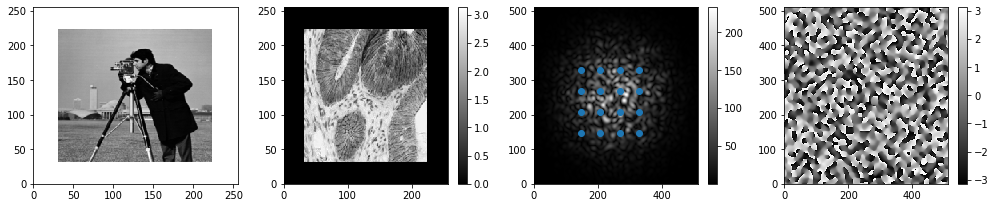

In [3]:
ptsim = NearFieldPtychographySimulation(positions_step_npix=60, probe_args={'photons_flux':1e3})

obj_center_positions = ptsim._positions + ptsim._obj_params.padded_npix // 2

fig, axs = plt.subplots(1, 4, figsize=[14,3])
cax0 = axs[0].pcolormesh(np.abs(ptsim._obj_padded), cmap='gray')
cax1 = axs[1].pcolormesh(np.angle(ptsim._obj_padded), cmap='gray')
cax2 = axs[2].pcolormesh(np.abs(ptsim._probe_true), cmap='gray')
axs[2].scatter(x=obj_center_positions.T[1], y=obj_center_positions.T[0])
cax3 = axs[3].pcolormesh(np.angle(ptsim._probe_true), cmap='gray')
plt.colorbar(cax1, ax=axs[1])
plt.colorbar(cax2, ax=axs[2])
plt.colorbar(cax3, ax=axs[3])
plt.tight_layout()
plt.show()

## LMA - reconstructing the object only

In [4]:
pr = LMAPhaseRetriever(ptsim=ptsim, probe_recons=False, validation_ndiffs=2)
pr.setOptimizingParams()
pr.initSession()

W0926 14:27:55.005568 140221243479872 deprecation_wrapper.py:119] From /raid/home/skandel/code/sopt/sopt/examples/tensorflow/near_field_ptychography/tfPtycho.py:91: The name tf.get_variable is deprecated. Please use tf.compat.v1.get_variable instead.

W0926 14:27:55.485683 140221243479872 deprecation.py:323] From /raid/home/skandel/miniconda3/envs/ad/lib/python3.7/site-packages/tensorflow/python/ops/clip_ops.py:157: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0926 14:27:55.496144 140221243479872 deprecation_wrapper.py:119] From /raid/home/skandel/code/sopt/sopt/examples/tensorflow/near_field_ptychography/tfPtycho.py:258: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.

W0926 14:27:55.505908 140221243479872 deprecation.py:323] From /raid/home/skandel/code/sopt/sopt/examples/tensorf

ValueError: Expected op/tensor name to start with gradients (excluding scope), got: obj_opt_gngvp/vjp/Complex_4_grad/Reshape:0. This means that a tf.gradients op with this op in its dependency path has a custom name that does not start with 'gradients'. Please make sure all calls to tf.gradients that have non-empty 'name' arguments use names that start with 'gradients'.

In [ ]:
pr.run(improvement_threshold=1e-4)


In [11]:
pr.data.tail(n=1)

,loss,epoch,obj_error,probe_error,validation_loss,patience
15,474378.34375,15.0,0.010914,NaN,71036.15625,50.0


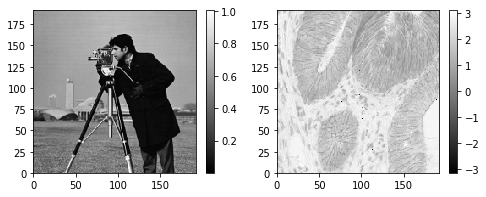

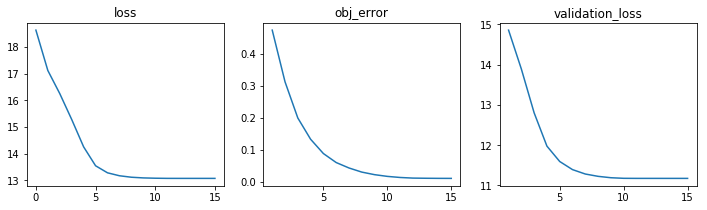

In [13]:
pr.genPlotsRecons()
pr.genPlotMetrics()

In [14]:
with pr.graph.as_default():
    run_meta = tf.RunMetadata()
    opts = tf.profiler.ProfileOptionBuilder.float_operation()    
    flops_lma_and_fwd = tf.profiler.profile(run_meta=run_meta, cmd='scope', options=opts) 
    flops_lma_and_fwd = flops_lma_and_fwd.total_float_ops
    print(f'{flops_lma_and_fwd:4.3g}')

# To calculate the flops required for one conjugate gradient step (within the LMA routine),
# I am isolating the nodes involved in the conjugate gradient calculation.
# Since the conjugate gradient loop is self-contained, we can estimate the cost of
# each cg iteration in this fashion.
graph_def = pr.graph.as_graph_def()
nodes_cg = [node for node in graph_def.node if 'cg_while' in node.name]
flops_cg = get_flops_for_node_list(pr.graph, nodes_cg)

nodes_validation = [node for node in graph_def.node if 'validation' in node.name]
flops_validation = get_flops_for_node_list(pr.graph, nodes_validation)
print(f'flops_cg {flops_cg:4.3g}  flops_validation {flops_validation:4.3g}')

cg_iter_count = pr.session.run(pr._optparams.obj_optimizer._total_cg_iterations)
outer_iterations = pr.data.index[-1] #session.run(opt._iteration)

total_flops = (flops_lma_and_fwd - flops_validation) * outer_iterations + (cg_iter_count - outer_iterations) * flops_cg
print(f'total flops {total_flops:4.3g}')

Instructions for updating:
Use tf.compat.v1.graph_util.remove_training_nodes
9.16e+09
flops_cg 2.43e+09  flops_validation 1.19e+08
total flops 8.75e+11
